In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

# 머신러닝 심화반 실습 예제 - 로지스틱 회귀(Logistic Regression)

이번 과제는 간단한 더미 데이터를 활용해 머신러닝(Machine Learning) 알고리즘 중 하나인 로지스틱 회귀(Logistic Regression)를 살펴보겠습니다.

이전에 배운 선형 회귀(Linear Regression)를 기반으로, 1) 출력값(Output Values)을 범주형(Categorical) 데이터로 만들기 위해, 스쿼싱 함수(Squashing Function)로 시그모이드(Sigmoid)를 사용하며, 2) 시그모이드(Sigmoid)를 추가할 경우 비용 함수(Cost Function)를 미분하면 경사가 울퉁불퉁해지는 현상을 방지하기 위해, 기존 선형 회귀에서 사용하던 MSE(Mean Squared Error)가 아닌, 크로스 엔트로피(Cross Entropy)라는 새로운 비용 함수를 사용할 것입니다.

이 두 가지 기능만 추가하면, 이전에 사용한 선형 회귀와 마찬가지로 경사 하강법(Gradient Descent)을 통해 이 머신러닝 알고리즘을 학습시킬 수 있습니다. 그럼 실제 예시를 보여드리도록 하겠습니다.

### Prerequisites

먼저 이번 실습 예제에서 사용할 패키지들을 가져오겠습니다. 오늘 필요한 파이썬 패키지는 벡터와 행렬 연산을 하는데 도움이 되는 패키지 넘파이(Numpy)와, 머신러닝 알고리즘의 학습 결과를 시각화를 통해 분석하기 위한 데이터 시각화 패키지 matplotlib만 있으면 충분합니다.

In [2]:
# matplotlib로 시각화한 결과물을 쥬피터 노트북에서 직접(inline) 출력하도록 명령하는 코드입니다.
%matplotlib inline

# 파이썬에서 벡터 연산과 행렬 연산을 도와주는 패키지 넘파이(Numpy)를 가져옵니다.
# 이를 줄여서 np라는 축약어로 사용합니다.
import numpy as np

# 파이썬에서 데이터 시각화를 다루는 패키지 matplotlib를 가져옵니다.
# 이를 줄여서 plt라는 축약어로 사용합니다.
import matplotlib.pyplot as plt

### Generate Dataset

이제 로지스틱 회귀(Logistic Regression)를 가장 잘 이해할 수 있는 데이터셋을 예시로 만들어보겠습니다.

오늘 여러분들은 국내 최고의 IT회사 A전자의 인사(HR) 업무를 지원하는 데이터 사이언티스트로서 일을 하게 됩니다. 이번에 할 일은 A전자에 입사한 신입 데이터 사이언티스트를 대상으로, 입사 2년이 지났을 경우 해당 직원이 다른 회사로 이직을 할 것인지를 예측하는 예측 모델을 머신러닝 알고리즘으로 구현할 것입니다.

이직 여부를 예측하기 위해서 중요한 요소는 다음과 같습니다.

* **연봉** - 입사후 매 년 인사 고과에 따라 연봉이 인상되는데, 이 연봉이 많이 오를수록 다른 회사로 옮길 가능성이 줄어들 것입니다. (단 입사 시 연봉은 전부 동일하게 4,800만 원으로 간주하겠습니다)
* **업무 만족도** - 연봉 외적으로, 회사에서 지금 맡고 일에 대한 만족도 점수입니다. 1점부터 10점까지이며, 높을 수록 업무 만족도가 높다고 가정하겠습니다. (마찬가지로 높을 수록 다른 회사로 옮길 가능성이 줄어들 것입니다)

이 데이터가 머신러닝 알고리즘에서 사실상 Feature가 될 것입니다. 두 가지 데이터의 예시는 다음과 같습니다.

In [3]:
# A전자 신입사원 10명의 2년 후 연봉 정보를 가져옵니다.
# 이를 salaries 라는 이름의 변수에 넣은 뒤, 행렬 연산을 편하게 하기 위해 넘파이(Numpy)의 배열(Array)로 변경해줍니다.
# 단, 여기서 편의를 위해 단위는 1,000만 원으로 하겠습니다. (가령 5.0이면 연봉 5,000만 원)
salaries = [5.0, 5.3, 5.1, 5.8, 5.05, 5.0, 5.3, 4.9, 5.15, 5.05]
salaries = np.array(salaries)

# salaries 변수에 들어가 있는 값을 출력합니다.
salaries

array([5.  , 5.3 , 5.1 , 5.8 , 5.05, 5.  , 5.3 , 4.9 , 5.15, 5.05])

In [4]:
# A전자 신입사원 10명의 업무 만족도 정보를 가져옵니다. 점수는 1점부터 10점으로 구성되어 있습니다.
# 이를 satisfactions 라는 이름의 변수에 넣은 뒤,
# 행렬 연산을 편하게 하기 위해 넘파이(Numpy)의 배열(Array)로 변경해줍니다.
satisfactions = [3, 7, 4, 9, 8, 6, 5, 4, 6, 7]
satisfactions = np.array(satisfactions)

# satisfactions 변수에 들어가 있는 값을 출력합니다.
satisfactions

array([3, 7, 4, 9, 8, 6, 5, 4, 6, 7])

그리고 위 신입 사원들의 이직 여부(회사 잔류 여부)를 표현한 데이터를 생성합니다. 이 데이터가 마찬가지로 오늘 다룰 머신러닝 알고리즘의 Label이 될 것입니다.

In [5]:
# A전자 신입사원 10명의 이직 여부(회사 잔류 여부)를 저장합니다.
# 이직하기 않고 회사에 남아있는 경우 True라는 값을 넣으며, 정 반대로 다른 회사로 이직했을 경우 False라는 값을 넣습니다.
# 이를 stay 라는 이름의 변수에 넣은 뒤,
# 행렬 연산을 편하게 하기 위해 넘파이(Numpy)의 배열(Array)로 변경해줍니다.
stay = [False, True, False, True, True, True, True, False, True, True]
stay = np.array(stay)

# stay 변수에 들어가 있는 값을 출력합니다.
stay

array([False,  True, False,  True,  True,  True,  True, False,  True,
        True])

마지막으로 위에서 생성한 Feature와 Label를 직관적으로 확인할 수 있도록 표(table) 형식으로 정리하여 출력하겠습니다.

In [6]:
# 파이썬에서 데이터를 분석하는데 도움을 주는 패키지 판다스(Pandas)를 가져옵니다.
# 이를 줄여서 pd라는 축약어로 사용합니다.
import pandas as pd

# 앞서 생성한 데이터를 하나로 묶어서 표(table)로 표현합니다.
# 이 결과를 example이라는 이름의 변수에 할당합니다.
example = pd.DataFrame({'연봉': salaries, '업무 만족도': satisfactions, '잔류': stay})

# example 변수에 들어가 있는 값을 출력합니다.
example

,연봉,업무 만족도,잔류
0,5.00,3,False
1,5.30,7,True
2,5.10,4,False
3,5.80,9,True
4,5.05,8,True
5,5.00,6,True
6,5.30,5,True
7,4.90,4,False
8,5.15,6,True
9,5.05,7,True


위 데이터를 matplotlib를 활용하여 시각화를 할 수도 있습니다.

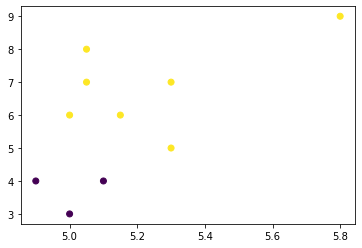

In [7]:
# 위 데이터를 바탕으로 연봉과 업무 만족도가 이직에 얼마나 영향을 미치는지 시각화 할 수 있습니다.
plt.scatter(salaries, satisfactions, c=stay)

### Define Sigmoid
이제 로지스틱 회귀(Logistic Regression)을 돌리기 위해 필요한 기능을 구현하겠습니다. 먼저 스쿼싱 함수(Squashing Function)로 사용할 시그모이드(Sigmoid)를 직접 구현해보겠습니다. 시그모이드 함수의 공식은 다음과 같습니다.

$$\text{sigmoid(x)}  = \frac{1}{1 + e^{-x}} $$

이 공식을 그래프로 시각화 하면 다음과 같이 나올 것입니다.

![pic.jpg](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/320px-Logistic-curve.svg.png)

이제 위에서 설명한 내용을 바탕으로 시그모이드 함수를 직접 구현해보겠습니다. 시그모이드 함수를 구현하기 위해서는 넘파이(Numpy)에서 지수 함수(exponential fucntion)를 계산하는 ```np.exp```를 사용해야 합니다.

In [8]:
# sigmoid라는 이름의 함수를 정의합니다. 이 함수에서는 x라는 값을 인자(argument)로 받습니다.
def sigmoid(x):
    # 위에서 설명한 시그모이드 공식을 그대로 파이썬으로 구현합니다.
    return 1 / (1 + np.exp(-x))

이제 위에서 구현한 시그모이드 함수를 직접 시각화 해보겠습니다.

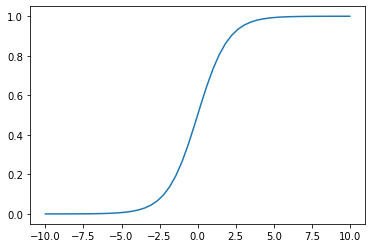

In [9]:
# 넘파이(Numpy)를 활용해 -10에서 +10까지 균등하게 값을 생성합니다. (약 50개)
# 이를 xx라는 변수에 할당합니다.
xx = np.linspace(-10, 10)

# 위 xx라는 변수에 들어간 값 전체에 시그모이드(sigmoid) 함수를 적용합니다.
# 이를 yy라는 변수에 할당합니다.
yy = sigmoid(xx)

# 위 xx를 x축으로, yy를 y축으로 하는 그래프를 시각화해서 출력합니다. 
plt.plot(xx, yy)

### Define Cross-Entropy

그 다음으로는 로지스틱 회귀의 비용 함수(Cost Function)로 쓰이는 크로스 엔트로피(Cross Entropy)를 구현해볼 것입니다. 크로스 엔트로피 공식은 다음과 같습니다.

$$ J \big(y_i, h(x_i) \big) = \frac{1}{m} \sum_{i = 0}^{m} - y_i \log h(x_i) - (1 - y_i) \log \big(1 - h(x_i) \big) $$

여기서 $m$은 데이터의 총 개수, $y_i$는 $i$번째 Label, h(x_i)는 $i$번째 Label의 예측값이라고 가정하겠습니다.

이 공식은 로지스틱 회귀를 구현하는데 있어서 필수는 아닙니다. (실제 로지스틱 회귀를 구현할 때는 크로스 엔트로피가 아닌, 크로스 엔트로피를 w와 b로 편미분한 결과를 사용합니다) 하지만 크로스 엔트로피를 구현해놓으면 로지스틱 회귀가 학습되는 과정을 관찰하는데 있어서 큰 도움이 됩니다.

이 크로스 엔트로피의 결과가 줄어들수록 정답($y_i$)과 예측값($h(x_i)$)이 일치해가면서 모델이 정확하게 학습되고 있다고 가정할 수 있습니다. 이제 실제 이 공식을 구현해보겠습니다.

In [10]:
# cross_entropy라는 이름의 함수를 정의합니다.
# 이 함수에서는 정답을 actual로, 예측값을 predict로 받습니다.
# 또한 결과값이 발산하는것을 방지하는 eps라는 값을 인자(argument)로 받습니다.
def cross_entropy(actual, predict, eps=1e-15):
    # 실제 정답(actual)과 예측 값(predict)을 편하게 계산하기 위해
    # 넘파이(Numpy) 배열로 바꿔줍니다.
    actual = np.array(actual)
    predict = np.array(predict)
    
    # cross entropy는 log를 사용하면서 값이 무한대로 발산할 수 있다는 단점이 있습니다.
    # 이를 방지하기 위해 최소/최대값이 각각 0과 1에서 아주 살짝 벗어나도록 잘라(clip)줘야 합니다.
    clipped_predict = np.minimum(np.maximum(predict, eps), 1 - eps)
    
    # 앞서 설명한 크로스 엔트로피 공식을 그대로 파이썬으로 구현합니다.
    cost = actual * np.log(clipped_predict) + (1 - actual) * np.log(1 - clipped_predict)
    cost = -1.0 * cost.mean()

    # 이 결과를 함수에서 반환합니다.
    return cost

### Gradient Descent

이제 본격적으로 로지스틱 회귀 알고리즘을 학습시켜 보겠습니다. 먼저 앞서 생성한 두 개의 Feature(연봉(```salaries```), 업무 만족도(```satisfactions```)를 편의를 위해 각각 ```x1```과 ```x2```라는 변수에 넣겠습니다.

In [11]:
# 앞서 생성한 연봉(salaries)을 x1이라는 변수에 할당합니다.
x1 = salaries

# 비슷하게, 앞서 생성한 업무 만족도(satisfactions)를 x2라는 변수에 할당합니다.
x2 = satisfactions

그리고 비슷하게, 회사의 잔류 여부를 나타내는 ```stay```를 Label로 간주하고 ```y```라는 변수에 넣겠습니다.

In [12]:
# 회사의 잔류 여부(stay)을 y라는 변수에 할당합니다.
y = stay

이제 본격적으로 학습을 시작해봅시다. 두 개의 변수 ```x1```과 ```x2```를 가지고 있으니 총 세 개의 값, 바로 가중치(weight) ```w1```, ```w2```과, bias인 ```b```를 학습해야 합니다. 세 개를 변수로 정의한 뒤, 경사 하강법(Gradient Descent)을 이용해 로지스틱 회귀를 학습시켜줍니다.

학습은 모든 epoch이 끝날 때까지 반복할 수도 있지만, 여기서는 굳이 그럴 필요없이 정확도(accuracy)가 1.0에 도달하면 학습을 종료하도록 하겠습니다.

In [13]:
# 학습 횟수를 몇 번으로 할지를 num_epoch이라는 변수에 정의합니다.
num_epoch = 100

# 학습 속도를 나타내는 learning_rate 값을 정합니다.
# 이 수치가 높을수록 학습 속도가 빨라지나, 너무 과하게 높을 경우 학습이 발산되어 버릴 수 있으니 주의합니다.
# (이러한 설정값을 전문용어로 하이퍼패러미터(Hyperparameter)라고 합니다)
learning_rate = 1.0

# 학습해야 하는 가중치(weight, w)와 bias(b)를 먼저 정의해줍니다.
# 이 값은 -1.0에서 +1.0 사이의 랜덤한 값으로 세팅해주면 됩니다.
w1 = np.random.uniform(low=-1.0, high=1.0)
w2 = np.random.uniform(low=-1.0, high=1.0)
b = np.random.uniform(low=-1.0, high=1.0)

# 앞서 지정한 학습 횟수(num_epoch) 만큼 학습을 시작합니다.
for epoch in range(num_epoch):
    # 먼저 주어진 데이터와 weight, bias를 활용하여 y의 예측값을 구합니다.
    # 이를 y_predict라는 변수에 할당합니다.
    y_predict = w1 * x1 + w2 * x2 + b

    # 이 예측값을 sigmoid 함수를 활용하여 squashing 해줍니다.
    # 마찬가지로 y_predict라는 변수에 할당합니다.
    y_predict = sigmoid(y_predict)
    
    # 여기서는 threshold를 0.5로 해줍니다.
    # 곧 예측한 확률이 50%보다 크다면 우리는 y가 1일 것이라고 간주합니다. (정 반대는 0이라고 간주합니다)
    predict = y_predict > 0.5
    
    # 앞서 구현한 Cross Entropy를 계산합니다.
    # 이 숫자가 완만하게 줄어들수록 학습이 잘 진행되고 있다고 간주할 수 있습니다.
    cost = cross_entropy(y, y_predict)

    # 이 알고리즘을 예측한 값이 정답과 얼마나 일치하는지, 정확도(0.0 ~ 1.0 사이)를 측정합니다.
    accuracy = (predict == y).mean()
    
    # 일정 시간(반복 횟수 10회) 마다 학습 경과를 출력합니다.
    if epoch % 10 == 0:
        print(f"{epoch:3} cost = {cost:.6f} accuracy = {accuracy:.6f}")
    
    # 정확도가 1.0(100%) 라면 학습을 그만합니다.
    if accuracy == 1.0:
        break
        
    # 비용 함수(Cost Function)인 크로스 엔트로피(Cross Entropy)를 편미분한 결과를 바탕으로 weight와 bias를 update 해줍니다.
    # 우리는 이를 경사 하강법(Gradient Descent)라고 부릅니다.
    w1 = w1 - learning_rate * ((y_predict - y) * x1).mean()
    w2 = w2 - learning_rate * ((y_predict - y) * x2).mean()
    b = b - learning_rate * (y_predict - y).mean()


# 최종적으로 학습이 끝났으면 그 결과를 출력합니다.
print("----" * 10)
print(f"{epoch:3} cost = {cost:.6f} accuracy = {accuracy:.6f}")

  0 cost = 1.782390 accuracy = 0.700000
 10 cost = 6.444452 accuracy = 0.700000
----------------------------------------
 12 cost = 0.085112 accuracy = 1.000000


### Predict
로지스틱 회귀의 학습이 끝났으면, 이제 이 머신러닝 알고리즘을 활용하여 원하는 결과를 예측할 수 있습니다. 앞선 데이터를 그대로 활용하여,  A전자의 신입 데이터 사이언티스트들이 2년 후에 이직할 것인지 여부를 예측해 보도록 하겠습니다.

In [14]:
# 주어진 데이터와 weight, bias를 활용하여 y의 예측값을 구합니다.
# 이를 y_predict 라는 변수에 할당합니다.
y_predict = w1 * x1 + w2 * x2 + b

# 이 예측값을 sigmoid 함수를 활용하여 squashing 해줍니다.
# 마찬가지로 y_predict 라는 변수에 할당합니다.
y_predict = sigmoid(y_predict)

# 여기서는 threshold를 0.5로 해줍니다.
# 곧 예측한 확률이 50%보다 크다면 우리는 y가 1일 것이라고(=잔류할 것이라고) 간주합니다. (정 반대는 0이라고, 즉 퇴사할 것이라고 간주합니다)
predict = y_predict > 0.5
    
# 앞서 생성한 데이터를 하나로 묶어서 표(table)로 표현합니다.
# 이 결과를 result 라는 이름의 변수에 할당합니다.
result = pd.DataFrame({'연봉': salaries, '업무 만족도': satisfactions, '잔류': stay, '잔류(예측)': predict, '잔류(확률)': y_predict})

# result 변수에 들어가 있는 값을 출력합니다.
result

,연봉,업무 만족도,잔류,잔류(예측),잔류(확률)
0,5.00,3,False,False,0.012095
1,5.30,7,True,True,0.999683
2,5.10,4,False,False,0.204054
3,5.80,9,True,True,0.999998
4,5.05,8,True,True,0.999995
5,5.00,6,True,True,0.996307
6,5.30,5,True,True,0.800373
7,4.90,4,False,False,0.314873
8,5.15,6,True,True,0.994291
9,5.05,7,True,True,0.999847


### Visualize Decision Boundary

결과가 잘 나왔으면, 실제 로지스틱 회귀가 Label을 잘 분류하는지(=퇴사 여부를 예측할 수 있는지) 시각화 한 뒤 확인할 수 있습니다. 

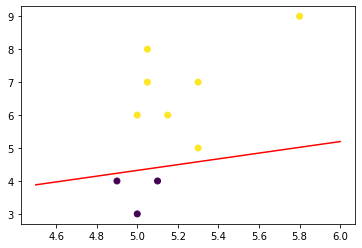

In [15]:
# -1에서 +1까지의 값 100개를 생성합니다.
xx = np.linspace(start=4.5, stop=6.0)

# Decision Boundary 공식을 활용하여 y값을 구합니다.
yy = -1.0 * (w1 * xx + b) / w2

# 주어진 데이터 x1과 x2, 그리고 y값을 시각화합니다.
plt.scatter(x1, x2, c=y)

# 그 사이에 존재하는 decision boundary를 빨간 선으로 시각화합니다.
plt.plot(xx, yy, c='r')

빨간 선이 회사에 잔류할 신입 사원과 그렇지 않은 신입 사원을 잘 구분하는 사실을 확인할 수 있습니다.